# HR Analytics - Predicting Employee Performance
### Olivia Wang - June 2020

### This analysis aims at providing insights into how ML can contribute to the decision making and effeciency of a company's human capital growth and return on investment.

Dataset from: https://drive.google.com/open?id=1ria5DGCPf7YPoBCu6JDPIJ1gPu7niCEi.

In [84]:
#Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

#### Preview Data Set

In [61]:
df = pd.read_excel('hr_dataset.xls')
df.head()

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


In [62]:
print(df.shape)

(1200, 28)


## 1. Examine the Data Set
- Determine which features are `continuous` and which are `categorical`
- Identify number of NAs in each column
- Identify number of unique values in each column

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
EmpNumber                       1200 non-null object
Age                             1200 non-null int64
Gender                          1200 non-null object
EducationBackground             1200 non-null object
MaritalStatus                   1200 non-null object
EmpDepartment                   1200 non-null object
EmpJobRole                      1200 non-null object
BusinessTravelFrequency         1200 non-null object
DistanceFromHome                1200 non-null int64
EmpEducationLevel               1200 non-null int64
EmpEnvironmentSatisfaction      1200 non-null int64
EmpHourlyRate                   1200 non-null int64
EmpJobInvolvement               1200 non-null int64
EmpJobLevel                     1200 non-null int64
EmpJobSatisfaction              1200 non-null int64
NumCompaniesWorked              1200 non-null int64
OverTime                        1200 non-null object
E

#### There are no missing values.

In [155]:
df.nunique(axis = 0)

Age                             43
Gender                           2
EducationBackground              6
MaritalStatus                    3
EmpDepartment                    6
EmpJobRole                      19
BusinessTravelFrequency          3
DistanceFromHome                29
EmpEducationLevel                5
EmpEnvironmentSatisfaction       4
EmpHourlyRate                   71
EmpJobInvolvement                4
EmpJobLevel                      5
EmpJobSatisfaction               4
NumCompaniesWorked              10
OverTime                         2
EmpLastSalaryHikePercent        15
EmpRelationshipSatisfaction      4
TotalWorkExperienceInYears      40
TrainingTimesLastYear            7
EmpWorkLifeBalance               4
ExperienceYearsAtThisCompany    37
ExperienceYearsInCurrentRole    19
YearsSinceLastPromotion         16
YearsWithCurrManager            18
Attrition                        2
PerformanceRating                3
dtype: int64

#### It appears that including `EmpNumber` will lead to information leakage as it is unique for each row, as a result, I will be dropping that feature.

In [64]:
df = df.drop(columns = ['EmpNumber'])

#### Identify `Continuous` and `Categorical` Features:

In [65]:
cat_var = list(df.select_dtypes(object).columns)

cont_var = list(df.columns[df.dtypes != object])
non_encode_cols = cont_var
cont_var.remove('PerformanceRating')
print('\nContinuous Variables are: ', cont_var)


Continuous Variables are:  ['Age', 'DistanceFromHome', 'EmpEducationLevel', 'EmpEnvironmentSatisfaction', 'EmpHourlyRate', 'EmpJobInvolvement', 'EmpJobLevel', 'EmpJobSatisfaction', 'NumCompaniesWorked', 'EmpLastSalaryHikePercent', 'EmpRelationshipSatisfaction', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear', 'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


#### Upon examination of the first few rows of the dataset, it appears that `EmpEnvironmentSatisfaction`, `EmpJobSatisfaction` and `EmpRelationshipSatisfaction` should fall under categorical variables.

In [66]:
con_to_cat = ['EmpEnvironmentSatisfaction', 'EmpJobSatisfaction', 'EmpRelationshipSatisfaction']
for col in con_to_cat:
    cat_var.append(col)
    cont_var.remove(col)
print('Categorical Variables are: ', cat_var)
print('\nContinuous Variables are: ', cont_var)

Categorical Variables are:  ['Gender', 'EducationBackground', 'MaritalStatus', 'EmpDepartment', 'EmpJobRole', 'BusinessTravelFrequency', 'OverTime', 'Attrition', 'EmpEnvironmentSatisfaction', 'EmpJobSatisfaction', 'EmpRelationshipSatisfaction']

Continuous Variables are:  ['Age', 'DistanceFromHome', 'EmpEducationLevel', 'EmpHourlyRate', 'EmpJobInvolvement', 'EmpJobLevel', 'NumCompaniesWorked', 'EmpLastSalaryHikePercent', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear', 'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


## 2. Visualize the univariate distribution of each continuous feature, and the distribution of the target.

In [67]:
to_plot = cont_var
to_plot.append('PerformanceRating')
to_plot2 = cat_var

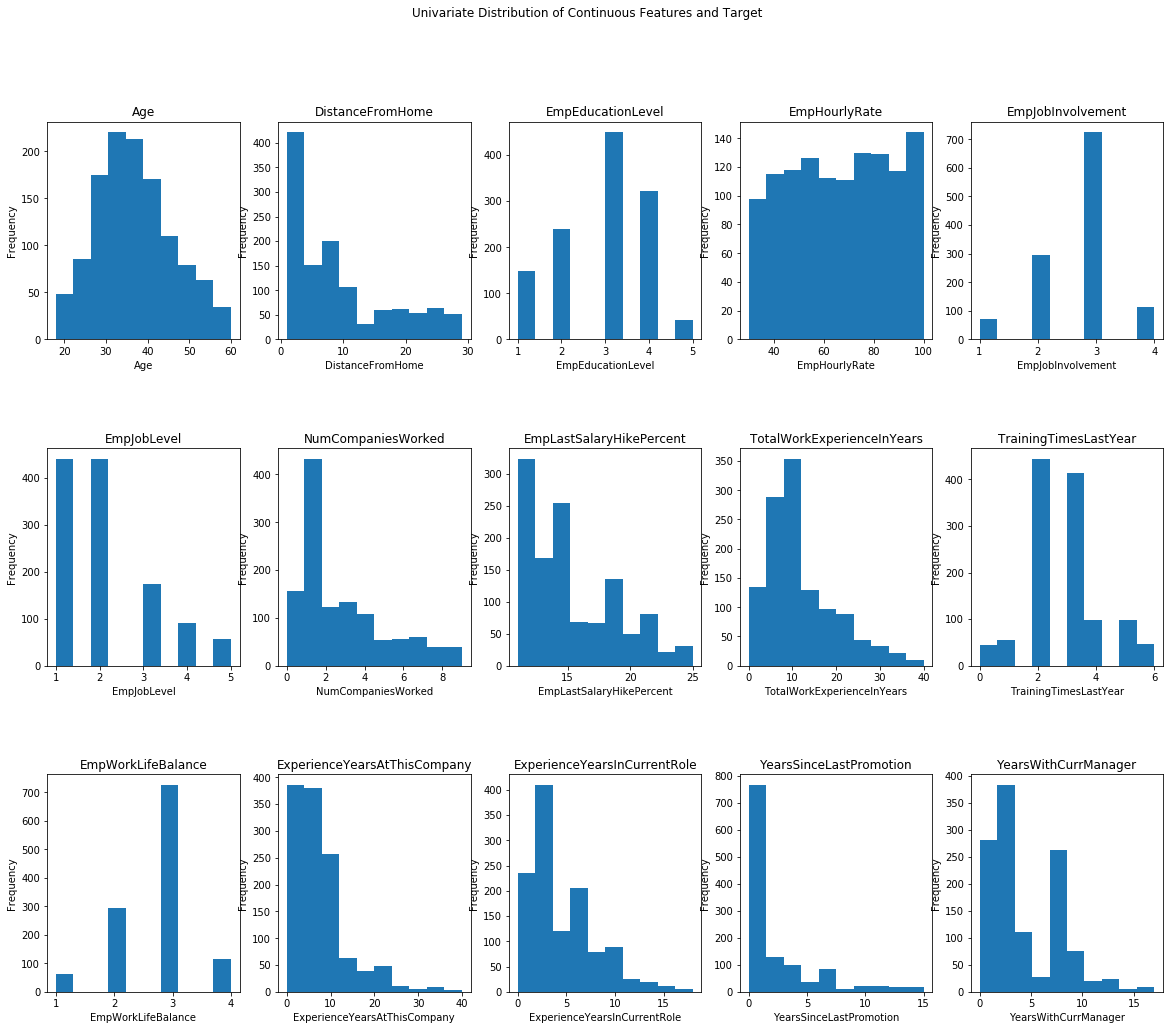

In [68]:
width = 5
fig, ax=plt.subplots(3, width, figsize=(20,16))
fig.suptitle('Univariate Distribution of Continuous Features and Target')
fig.subplots_adjust(hspace=0.5)
for row in range(len(ax)):
    for column in range(len(ax[0])):
        i = width*row +column
        ax[row,column].hist(df[to_plot[i]])
        if to_plot[i] != 'PerformanceRating':
            ax[row,column].title.set_text(to_plot[i])
            ax[row,column].set_xlabel(to_plot[i])
            ax[row,column].set_ylabel('Frequency')
        else:
            ax[row,column].title.set_text('Performance Rating (Target)')
            ax[row,column].set_xlabel('Performance Rating (Target)')
            ax[row,column].set_ylabel('Frequency')
plt.show()



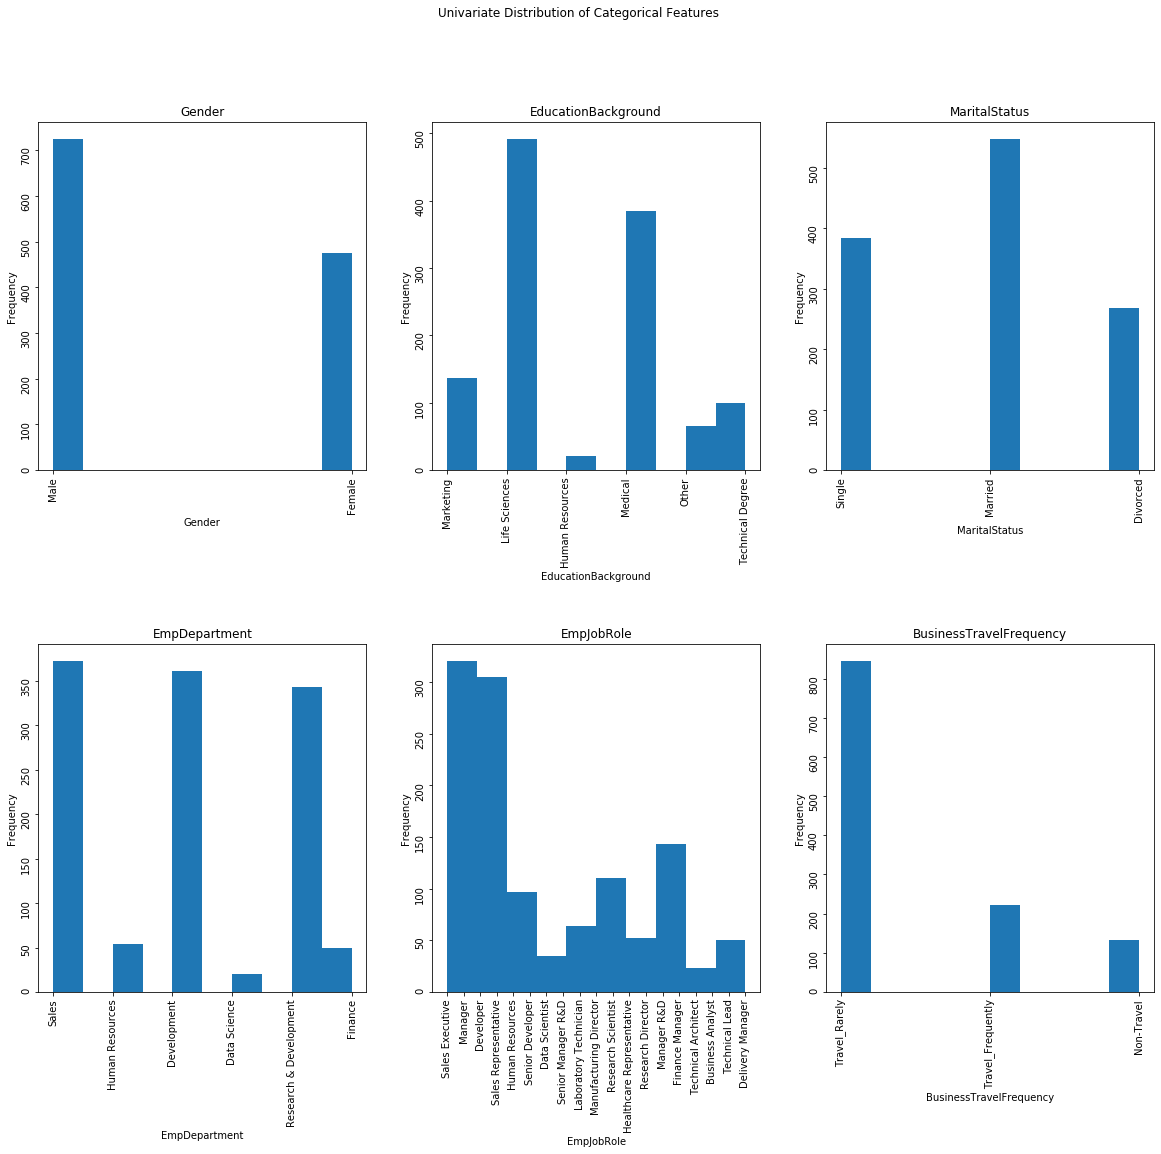

In [69]:
width = 3
fig, ax=plt.subplots(2, width, figsize=(20,16))
fig.suptitle('Univariate Distribution of Categorical Features')
fig.subplots_adjust(hspace=0.5)
for row in range(len(ax)):
    for column in range(len(ax[0])):
        i = width*row +column
        ax[row,column].hist(df[to_plot2[i]])
        ax[row,column].title.set_text(to_plot2[i])
        ax[row,column].set_xlabel(to_plot2[i])
        ax[row,column].set_ylabel('Frequency')
        ax[row,column].tick_params(labelrotation=90)

        
plt.show()

1. Life Sciences is the education background with the greatest number of employees, followed by Medical.
2. Data Science Department has the least number of employees.

## 3. Split data into training and test set & Preprocess data

In [70]:
target = df['PerformanceRating']

features = df.copy()
features = features.drop(columns = ['PerformanceRating'])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

### Get Baseline

In [72]:
X_train_enc = pd.get_dummies(data = X_train, columns = cat_var)
lr = LogisticRegression().fit(X_train_enc,y_train)
scores = np.mean(cross_val_score(LogisticRegression(), X_train_enc, y_train))
print(f'mean cv accuracy using logistic regression: {scores:0.3f}')

mean cv accuracy using logistic regression: 0.791


### Use ColumnTransformer and Pipeline to Encode Categorical Variables

In [73]:
preprocess = make_column_transformer((OneHotEncoder(), cat_var),
                                    (StandardScaler(), cont_var))

In [74]:
cont_var.remove('PerformanceRating')

In [157]:
classifier={'LR' : LogisticRegression(),
            'SVM' : LinearSVC(max_iter=5000),
            'KNN' : KNeighborsClassifier(),
            'RFC' : RandomForestClassifier(),
            'DTC' : DecisionTreeClassifier()}

In [158]:
for j in classifier:
    model = make_pipeline(preprocess, classifier[j])
    scores = cross_val_score(model, X_train, y_train, cv = 5)
    print("Accuracy of ", j, ':', scores.mean())

Accuracy of  LR : 0.8104166666666666
Accuracy of  SVM : 0.7968750000000001
Accuracy of  KNN : 0.734375
Accuracy of  RFC : 0.8979166666666666
Accuracy of  DTC : 0.8854166666666666


#### Since Random Forest Classifier and Decision Tree Classifier gave the best baseline training score, I will be performing grid search to find the optimal parameters.

In [96]:
# RandomForestClassifier Hyperparameter Tuning

pipe_grid = make_pipeline(preprocess,RandomForestClassifier(n_jobs = 2, oob_score = True, n_estimators = 500))
param_grid = {"randomforestclassifier__max_depth": [3, 5, 8, 10],
              "randomforestclassifier__min_samples_leaf": [1, 5, 10, 15],
              "randomforestclassifier__n_estimators": [100, 300, 500],
              
             }
rfc = GridSearchCV(pipe_grid, param_grid, cv = 5) 
rfc.fit(X_train, y_train)
print(f'The Best Score for Random Forest Classifier: {rfc.best_score_:.2f}') 
print(f'The Best Parameter for Random Forest Classifier: {rfc.best_params_}')

The Best Score for Random Forest Classifier: 0.90
The Best Parameter for Random Forest Classifier: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 500}


In [78]:
# DecisionTreeClassifier Hyperparameter Tuning

pipe_grid = make_pipeline(preprocess,DecisionTreeClassifier(criterion = "entropy", max_depth = 8, min_samples_leaf = 1, random_state = 0))
param_grid = {'criterion': ["gini", "entropy"],
              'max_depth': [3, 5, 8, 10],
              'min_samples_leaf': [1, 3, 5, 10]
             }
dtc = GridSearchCV(pipe_grid, param_grid, cv = 5) 
dtc.fit(X_train, y_train)
print(f'The Best Score for Decision Tree Classifier: {dtc.best_score_:.2f}') 
print(f'The Best Parameter for Decision Tree Classifier: {dtc.best_params_}')

The Best Score for Decision Tree Classifier: 0.92
The Best Parameter for Decision Tree Classifier: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 3}


#### Both models performed well with hyperparameter tuning, but I will be proceeding with the DecisionTreeClassifier

#### Applying the Decision Tree Classifier to the Test Set:

In [82]:
test_score = dtc.score(X_test, y_test)
print(f'The Test Score From the Model is {test_score:.2f}')

The Test Score From the Model is 0.91


## 4. Visualize Effect of Different Hyperparameters and Features on the Model Performance

### Effect of Max Depth and Min Samples Leaf on Decision Tree Classifier Performance:

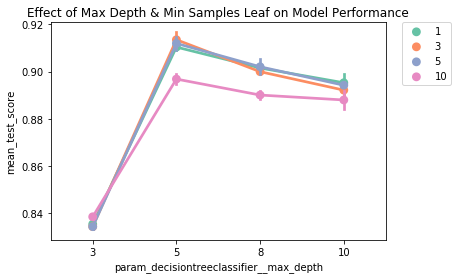

In [91]:
df_dtc = pd.DataFrame(data = dtc.cv_results_)
# print(df_dtc)
fig, ax = plt.subplots()
sns.pointplot(data = df_dtc,
             y = 'mean_test_score',
             x = 'param_decisiontreeclassifier__max_depth',
             hue = 'param_decisiontreeclassifier__min_samples_leaf',
             palette = 'Set2',
             ax = ax)
ax.set(title = 'Effect of Max Depth & Min Samples Leaf on Model Performance');
plt.legend(bbox_to_anchor = (1.05,1),loc = 2, borderaxespad = 0.);

### Most Important Features:

In [159]:
params = {'criterion' : 'gini', 'max_depth' : 5, 'min_samples_leaf' : 5}
model_dtc = DecisionTreeClassifier(**params)
pipe_dtc =Pipeline([("Preprocessor", preprocess),
                   ("scaler", model_dtc)]).fit(X_train, y_train)
feature_importance = sorted(pipe_dtc["scaler"].feature_importances_)
sorted_idx = feature_importance[-5:]

categorical = X_train.dtypes == 'object'
col_con = X_train[X_train.columns[~categorical]].columns

col_cat = pipe_dtc.named_steps['Preprocessor'].transformers_[0][1].get_feature_names()

all_column_names = np.array(list(col_con) + list(col_cat))
print('Top 5 Features In Determining Employee Performance')
for name, importance in zip(all_column_names, sorted_idx):
    print(name, importance)


Top 5 Features In Determining Employee Performance
Age 0.1046737359430455
DistanceFromHome 0.1390331894904945
EmpEducationLevel 0.16546807921919754
EmpEnvironmentSatisfaction 0.20511362194657073
EmpHourlyRate 0.2612058407324424


## 5. Conclusion

### After careful evaluation of the drawn observations, I can recommend the following to increase employee performance at an organization:
#### 1. Ensure a fair and competitive compensation package for employees.
#### 2. Create a  friendly, comfortable and inclusive office environment, and incorporate employee feedbacks when making adjustments regarding which.
#### 3. Invest in employee education such as online classes and frequent trainings to further the skill sets of current employees, so as to best prepare them for current and future responsibilities.
#### 4. Provide housing assistance in order to help employees locate accomodations that are closer to the company location and help them arrange easier work commutes.